# Zillow Time Series

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Zillow-Time-Series" data-toc-modified-id="Zillow-Time-Series-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Zillow Time Series</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Gather-Data" data-toc-modified-id="Gather-Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Gather Data</a></span></li><li><span><a href="#Helper-Functions" data-toc-modified-id="Helper-Functions-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Helper Functions</a></span></li><li><span><a href="#Choosing-Top-5-Zipcodes" data-toc-modified-id="Choosing-Top-5-Zipcodes-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Choosing Top 5 Zipcodes</a></span></li><li><span><a href="#Data-Preperation-and-Analysis" data-toc-modified-id="Data-Preperation-and-Analysis-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Data Preperation and Analysis</a></span><ul class="toc-item"><li><span><a href="#Checking-Seasonality" data-toc-modified-id="Checking-Seasonality-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Checking Seasonality</a></span></li><li><span><a href="#Checking-Monthly-Returns" data-toc-modified-id="Checking-Monthly-Returns-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Checking Monthly Returns</a></span></li><li><span><a href="#Checking-for-Stationarity" data-toc-modified-id="Checking-for-Stationarity-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Checking for Stationarity</a></span></li><li><span><a href="#Modeling-Each-Zipcode" data-toc-modified-id="Modeling-Each-Zipcode-6.4"><span class="toc-item-num">6.4&nbsp;&nbsp;</span>Modeling Each Zipcode</a></span><ul class="toc-item"><li><span><a href="#Charleston-29407" data-toc-modified-id="Charleston-29407-6.4.1"><span class="toc-item-num">6.4.1&nbsp;&nbsp;</span>Charleston 29407</a></span></li><li><span><a href="#Alexandria-56308" data-toc-modified-id="Alexandria-56308-6.4.2"><span class="toc-item-num">6.4.2&nbsp;&nbsp;</span>Alexandria 56308</a></span></li></ul></li></ul></li><li><span><a href="#Facebook-Prophet-Model" data-toc-modified-id="Facebook-Prophet-Model-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Facebook Prophet Model</a></span><ul class="toc-item"><li><span><a href="#Charleston-29407-FB" data-toc-modified-id="Charleston-29407-FB-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Charleston 29407 FB</a></span></li><li><span><a href="#Alexandria-FB" data-toc-modified-id="Alexandria-FB-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Alexandria FB</a></span></li></ul></li></ul></div>

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error as MSE

# Gather Data

In [2]:
# Loading Data. Data Has been obtained from https://www.zillow.com/research/data/
zillow_data = pd.read_csv('zillow_data.csv')
#Removing RegionID because RegionName is proper ZipCode
zillow_data.drop(columns = 'RegionID', inplace=True)
zillow_data.head()

,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,337600.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,235400.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,210700.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,504600.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


# Helper Functions

In [3]:
# Function created to change the format of columns from year-month to year-month-day
def get_datetimes(df):
    return pd.to_datetime(df.columns[7:].values[1:], format='%Y-%m')

In [4]:
#Change Wide formated data above into Long format
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

In [5]:
def train_test_split(df):
    #Set training data before 2016
    train = df[:'2015-04']
    #Set test data starting 2016
    test = df['2015-05':]
    return train, test

In [6]:
def seasonal_plots(df,N=13,lags=[12,24,36,48,60,72]):
    #Differencing the rolling mean to find seasonality in the resulting acf plot.
    fig,(ax1,ax2) = plt.subplots(2,1,figsize=(13,8))
    rolling = df - df.rolling(N).mean()
    plot_acf(rolling.dropna(),lags=lags,ax=ax1)
    plot_pacf(rolling.dropna(),lags=lags,ax=ax2)
    plt.show();

In [7]:
def model_fit(df, pdq, pdqs):
    train, test = train_test_split(df)
    model = SARIMAX(train,order=pdq,seasonal_order=pdqs)
    results = model.fit()
    results.summary
    residuals = results.resid
    print(results.summary())
    results.plot_diagnostics(figsize=(11,8))
    plt.show();
    return train, test, results


In [8]:
def test_RMSE(df,pdq,pdqs, display=True):
    X = df.values
    train, test = X[:-36],X[-36:]
    history = [x for x in train]
    predictions = []
    for t in range(len(test)):
        model = SARIMAX(history, order=pdq,seasonal_order=pdqs)
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        history.append(test[t])
    rmse = np.sqrt(MSE(test, predictions))
    print('SARIMA model RMSE on test data: %.5f' % rmse)
    if display:
        plt.figure(figsize=(13,6))
        plt.title('Actual Test Data vs. Predictions')
        plt.plot(history[-36:],label='Actual', color='b')
        plt.plot(predictions,label='Predictions',color='r')
        plt.legend(loc='best')
        plt.show()


In [9]:
def train_RMSE(df, results, display = True):
    train_pred = results.predict(-36)
    rmse = np.sqrt(MSE(train[-36:],train_pred))
    print(f'SARIMA model RMSE on train data: %.5f' % rmse)
    if display:
        plt.figure(figsize=(13,6))
        train[-60:].plot(label='Actual',color='b')
        train_pred.plot(label='Predicted',color='r')
        plt.legend(loc='best')
        plt.title('Actual Train Data vs. Predicted Returns')
        plt.show()

In [10]:
def forecast_model(df, pdq, pdqs, display=True,zc='input zipcode'):
    model = SARIMAX(df, order=pdq,seasonal_order=pdqs)
    model_fit = model.fit()
    output = model_fit.get_prediction(start='2018-04',end='2030-04', dynamic=True)
    forecast_ci = output.conf_int()
    if display:
        fig, ax = plt.subplots(figsize=(13,6))
        output.predicted_mean.plot(label='Forecast')
        ax.fill_between(forecast_ci.index,forecast_ci.iloc[:, 0],forecast_ci.iloc[:, 1],
                        color='k', alpha=.25,label='Conf Interval')
        plt.title('Forecast of Monthly Returns')
        plt.xlabel('Time')
        plt.legend(loc='best')
        plt.show()
    year_1= (1+output.predicted_mean[:12]).prod()-1
    year_5= (1+output.predicted_mean[:60]).prod()-1
    year_10=(1+output.predicted_mean).prod()-1
    print(f'Total expected return in 1 year: {round(year_1*100,2)}%')
    print(f'Total expected return in 5 year: {round(year_5*100,2)}%')
    print(f'Total expected return in 10 years: {round(year_10*100,2)}%')
    Returns = [zc, year_1, year_5, year_10]
    return Returns

# Choosing Top 5 Zipcodes

So For this project we will be dealing with the the top 30% is size rank. After reasearch, Size rank is the level of urbanization that the city has.

In [11]:
size_rank_ = zillow_data.SizeRank.quantile(q=.3)
zillow_size_rank_ = zillow_data[zillow_data['SizeRank'] < size_rank_]
zillow_size_rank_.head()

,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,337600.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,235400.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,210700.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,504600.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


To further cut down on data to identify the top 5 zip codes, I have created an upper and lower bound based on the yearly average. 

In [12]:
#Get the Average Housing Price from our dataset.
zillow_size_rank_['YearAvg'] = zillow_size_rank_.iloc[:-12].mean(skipna=True, axis=1)

# Establish a cutt off value for our dataset based on mean price(upper Value)
cutt_off_1 = zillow_size_rank_.YearAvg.quantile(q = .7)

# Establish a cutt of value for our dataset based on mean price(lower value)
cutt_off_2 = zillow_size_rank_.YearAvg.quantile(q=.3)

#Prefered zipcode, a dataframe created off of the preference created above
zillow_preference = zillow_size_rank_[(zillow_size_rank_.YearAvg < cutt_off_1) & 
                                      (zillow_size_rank_.YearAvg>cutt_off_2)]

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Here I want to gather more information about the data. Things such as return on investment, the standard deviation, the mean, and the coefficient of variance

In [13]:
#Calculate historical return on investment[roi]
zillow_preference['roi'] = (zillow_preference['2018-04']/zillow_preference['1996-04'])-1

#Standard Deviation of Monthly values[std]
zillow_preference['std'] = zillow_preference.loc[:,'1996-04':'2018-04'].std(skipna=True, axis=1)

#Historical mean Value[mean]
zillow_preference['mean'] = zillow_preference.loc[:,'1996-04':'2018-04'].mean(skipna=True, axis=1)

#Coefficient of variance[cv]
zillow_preference['CV'] = zillow_preference['std']/zillow_preference['mean']

#Return dataframe
zillow_preference[['RegionName','std','mean','roi','CV']].head()

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

,RegionName,std,mean,roi,CV
1,75070,33537.101427,219655.849057,0.365295,0.152680
11,32162,53805.394161,183692.830189,1.493069,0.292910
14,37013,19771.938500,139191.698113,0.885231,0.142048
17,37211,36496.608464,147387.924528,1.698672,0.247623
18,78660,24894.592870,168193.584906,0.748020,0.148012


Defining an upper coefficient of variance giving me the "Risk Involved"

In [14]:
#Define upper limit of risk
upper_cv = zillow_preference.CV.quantile(.75)
df = zillow_preference[zillow_preference['CV']<upper_cv].sort_values('roi',axis=0,ascending=False)[:5]

In [15]:
df[['City', 'RegionName','roi','CV']]

,City,RegionName,roi,CV
1236,Charleston,29407,2.898833,0.286769
1052,Charleston,29412,2.892435,0.288194
2974,Alexandria,56308,2.670051,0.251144
1540,Minneapolis,55406,2.475342,0.276417
2165,Sherrelwood,80221,2.380192,0.282805


In [16]:
df.drop(['City', 'State', 'Metro', 'CountyName', 'SizeRank','YearAvg', 'roi',
       'std', 'mean', 'CV'], axis=1, inplace=True)

In [17]:
df

,RegionName,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
1236,29407,77100.0,77400.0,77900.0,78400.0,79000.0,79700.0,80600.0,81600.0,82700.0,...,276200,278600,282200,285300,288700,292000,294500,296200,298800,300600
1052,29412,84600.0,85100.0,85900.0,86800.0,87800.0,89000.0,90300.0,91700.0,93300.0,...,308400,310200,313400,316500,318300,320000,321900,324100,327100,329300
2974,56308,59100.0,59300.0,59400.0,59500.0,59500.0,59400.0,59200.0,59100.0,59100.0,...,200300,201300,203300,205500,207100,208400,210500,212900,215200,216900
1540,55406,73000.0,73300.0,73400.0,73600.0,73900.0,74100.0,74400.0,74600.0,75000.0,...,236100,238000,239500,241300,243400,245700,247900,249500,251800,253700
2165,80221,93900.0,94400.0,95000.0,95600.0,96200.0,96800.0,97500.0,98200.0,99000.0,...,292200,295400,298200,299800,301700,304700,307400,310400,314600,317400


# Data Preperation and Analysis

We have to melt our data into the proper format to be able to run time series

In [18]:
#Melting Data into desired format
zc5 = melt_data(df).set_index('time')
print('Time series data for the 5 zipcodes:\n', zc5.head())

Time series data for the 5 zipcodes:
             RegionName    value
time                           
1996-04-01       29407  77100.0
1996-04-01       29412  84600.0
1996-04-01       56308  59100.0
1996-04-01       55406  73000.0
1996-04-01       80221  93900.0


I Created a list of the top 5 zip codes to be able to run for loops and if statements and have it affect the entire dataset if I choose

In [19]:
#List containing the 5 different time series.
dfs_ts = []
for zc in zc5.RegionName:
    #Create separate dataframes for each zipcode with a monthly frequency.
    df = zc5[zc5['RegionName']==zc]
    dfs_ts.append(df)
print('\nZipcode 29407 time series:')
dfs_ts[0]


Zipcode 29407 time series:


,RegionName,value
time,,
1996-04-01,29407,77100.0
1996-05-01,29407,77400.0
1996-06-01,29407,77900.0
1996-07-01,29407,78400.0
1996-08-01,29407,79000.0
...,...,...
2017-12-01,29407,292000.0
2018-01-01,29407,294500.0
2018-02-01,29407,296200.0


## Checking Seasonality

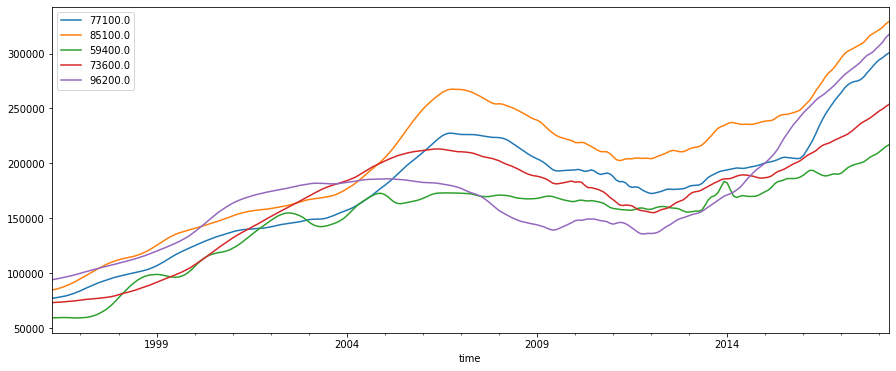

In [20]:
#Checking for seasonality in Data
for i in range(5):
    dfs_ts[i].value.plot(label=dfs_ts[i].value[i],figsize=(15,6))
    plt.legend() 

## Checking Monthly Returns

In [21]:
#Calculate monthly returns in new column for top 5 zipcodes
for zc in range(5):
    dfs_ts[zc]['Return']=np.nan*len(dfs_ts[zc])
    for i in range(len(dfs_ts[zc])-1):
        dfs_ts[zc]['Return'][i+1]= (dfs_ts[zc].value.iloc[i+1] / dfs_ts[zc].value.iloc[i]) - 1


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

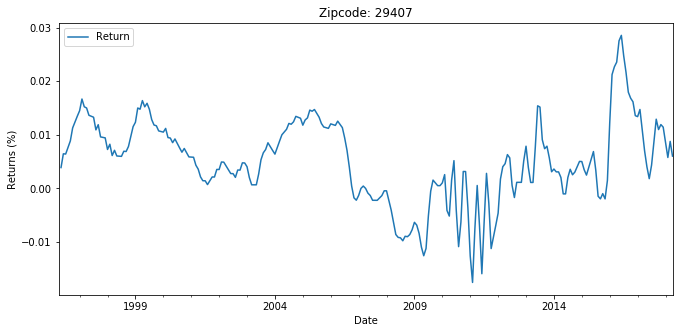

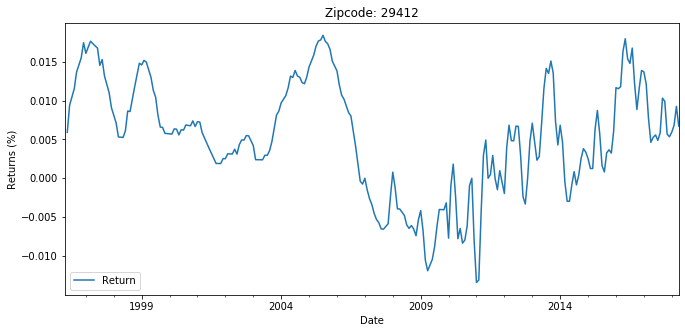

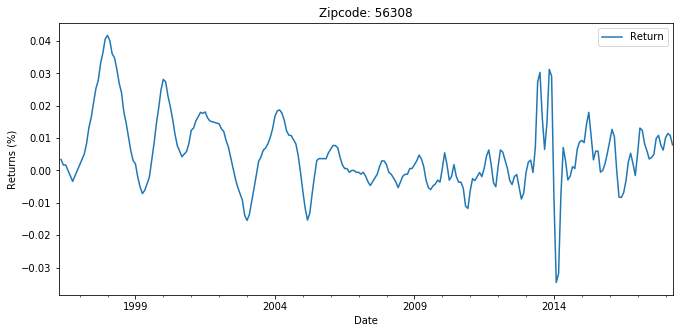

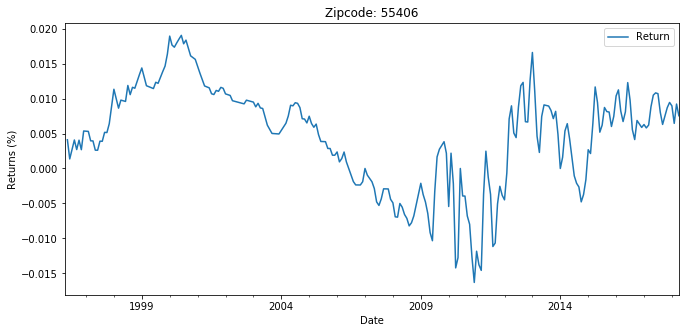

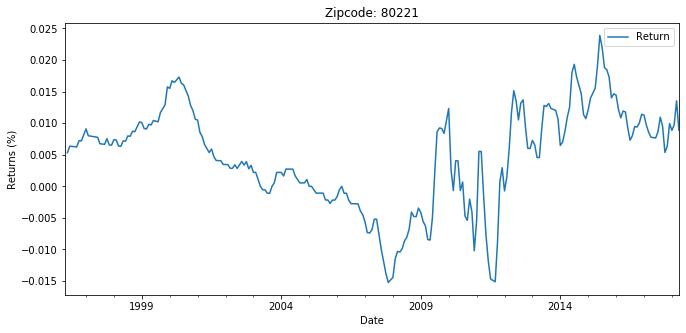

In [22]:
# Monthly Return for Zipcodes
for i in range(5):
    dfs_ts[i].Return.plot(figsize=(11,5))
    plt.title(f'Zipcode: {dfs_ts[i].RegionName[i]}')
    plt.xlabel('Date')
    plt.ylabel('Returns (%)')
    plt.legend()
    plt.show()


## Checking for Stationarity

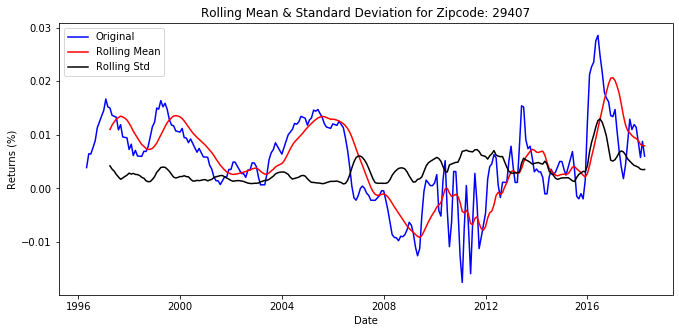

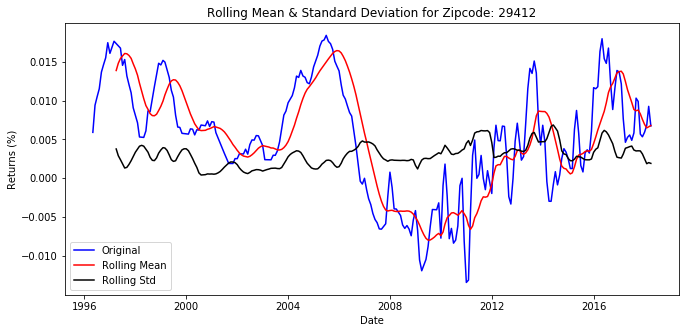

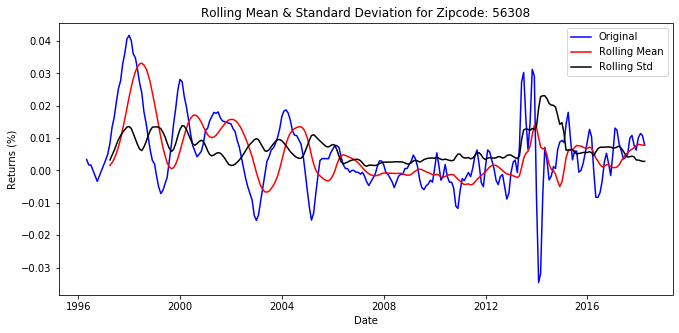

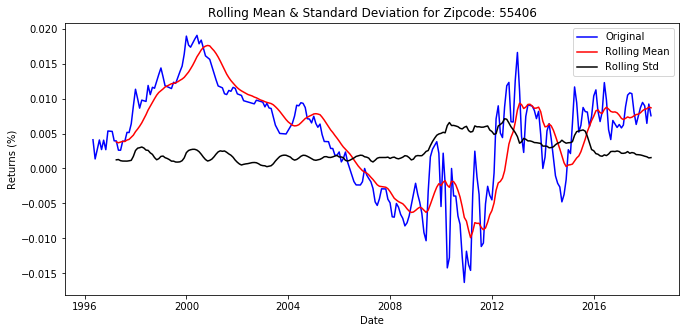

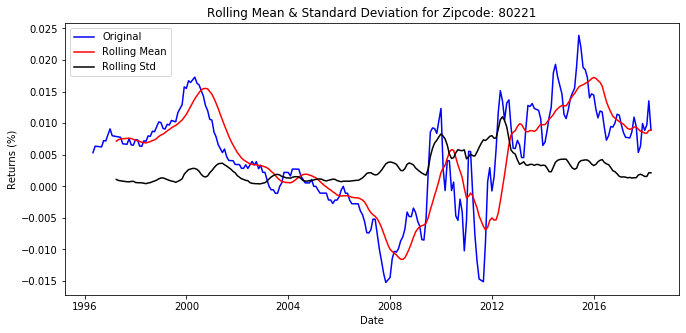

In [23]:
#Vizually test for stationarity with rolling mean and rolling standard deviation
for i in range(5):
    rolmean = dfs_ts[i].Return.rolling(window = 12, center = False).mean()
    rolstd = dfs_ts[i].Return.rolling(window = 12, center = False).std()
    fig = plt.figure(figsize=(11,5))
    orig = plt.plot(dfs_ts[i].Return, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.xlabel('Date')
    plt.ylabel('Returns (%)')
    plt.legend()
    plt.title(f'Rolling Mean & Standard Deviation for Zipcode: {dfs_ts[i].RegionName[i]}')
    plt.show()

To get the best understanding on if our data is stationary or not we are going to preform a dickey fuller test on each of the zipcodes

In [24]:
#perform dickey fuller to see if our data is stationary
for i in range(5):
    results = adfuller(dfs_ts[i].Return.dropna())
    print(f'ADFuller test p-value for zipcode: {dfs_ts[i].RegionName[i]}')
    print('p-value:',results[1])
    if results[1]>0.05:
        print('Fail to reject the null hypothesis. Data is not stationary.\n')
    else:
        print('Reject the null hypothesis. Data is stationary.\n')

ADFuller test p-value for zipcode: 29407
p-value: 0.12787550269306985
Fail to reject the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 29412
p-value: 0.08063578652833103
Fail to reject the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 56308
p-value: 0.029872060036786306
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 55406
p-value: 0.32741456447517925
Fail to reject the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 80221
p-value: 0.36126276622751596
Fail to reject the null hypothesis. Data is not stationary.



For data that is not stationary, i applied differencing. After rechecking if my data is stationary we can more forward onto modeling

In [25]:
for i in [0, 1, 3, 4]:
    #Perform adfuller test and drop NaN values created when calculating monthly returns.
    results = adfuller(dfs_ts[i].Return.diff().dropna())
    print(f'ADFuller test p-value for zipcode: {dfs_ts[i].RegionName[i]}')
    print('p-value:',results[1])
    if results[1]>0.05:
        print('Fail to reject the null hypothesis. Data is not stationary.\n')
    else:
        print('Reject the null hypothesis. Data is stationary.\n')

ADFuller test p-value for zipcode: 29407
p-value: 1.0862012530812873e-07
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 29412
p-value: 7.289838231385235e-15
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 55406
p-value: 0.0002447313236647397
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 80221
p-value: 0.0002741061115500892
Reject the null hypothesis. Data is stationary.



## Modeling Each Zipcode

In [26]:
#List to help me remeber each zipcode and corresponding city name
#Charleston 29407
#Charleston 29412
#Alexandria 56308
#Minneapolis 55406
#Sherrelwood 80221
dfs_ts[0].drop(['RegionName'], axis=1, inplace=True)
dfs_ts[1].drop(['RegionName'], axis=1, inplace=True)
dfs_ts[2].drop(['RegionName'], axis=1, inplace=True)
dfs_ts[3].drop(['RegionName'], axis=1, inplace=True)
dfs_ts[4].drop(['RegionName'], axis=1, inplace=True)

dfs_ts[0].rename(columns={"Return": "y"}, inplace=True)
dfs_ts[1].rename(columns={"Return": "y"}, inplace=True)
dfs_ts[2].rename(columns={"Return": "y"}, inplace=True)
dfs_ts[3].rename(columns={"Return": "y"}, inplace=True)
dfs_ts[4].rename(columns={"Return": "y"}, inplace=True)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


Now we create a data frame for each of our zip codes, dropping nan's and differencing for our data that was non stationary

In [27]:
ts_1 = dfs_ts[0].y.dropna()
ts_1d = dfs_ts[0].y.diff().dropna()


ts_3 = dfs_ts[2].y.dropna()


### Charleston 29407

To get our AR, and MA terms we create and ACF and PACF plot

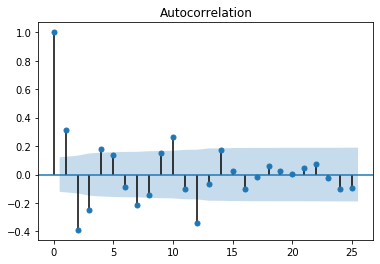

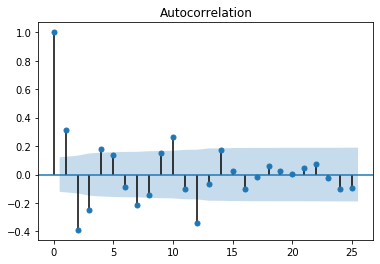

In [29]:
plot_acf(ts_1d[:-1], alpha=.05)

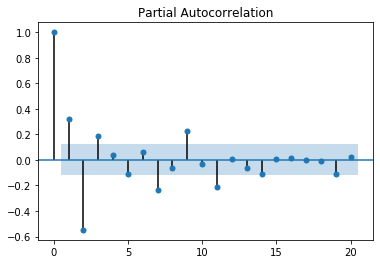

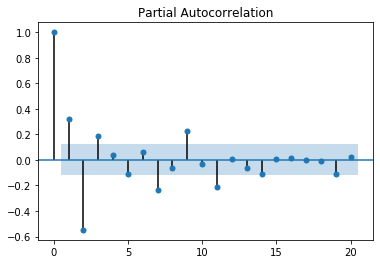

In [30]:
plot_pacf(ts_1d[:-1], alpha=.05, lags=20)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


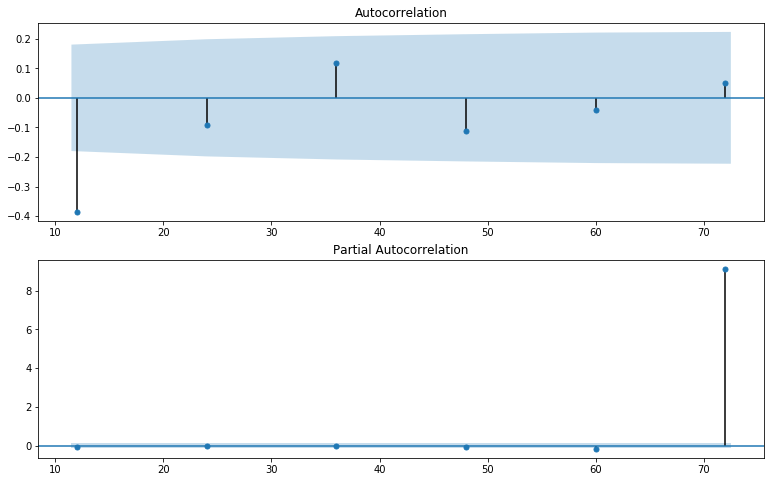

In [31]:
seasonal_plots(ts_1d[:-1])

Fitting the data, and using our AR and MA terms from our plots we can fit the model

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  227
Model:               SARIMAX(3, 0, 1)   Log Likelihood                1080.342
Date:                Wed, 17 Jun 2020   AIC                          -2150.685
Time:                        22:49:58   BIC                          -2133.560
Sample:                    06-01-1996   HQIC                         -2143.775
                         - 04-01-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1612      0.448      0.360      0.719      -0.717       1.040
ar.L2         -0.5315      0.184     -2.895      0.004      -0.891      -0.172
ar.L3         -0.0992      0.276     -0.360      0.7

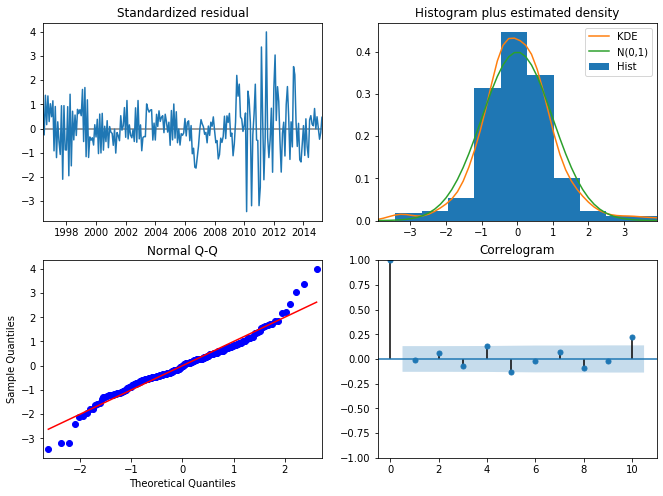

In [32]:
#Fit the SARIMA model and get results.
pdq = (3,0,1) #(AR, D, MA)
pdqs = (0,0,0,12)
train, test, results = model_fit(ts_1d, pdq=pdq, pdqs=pdqs)

SARIMA model RMSE on train data: 0.00201


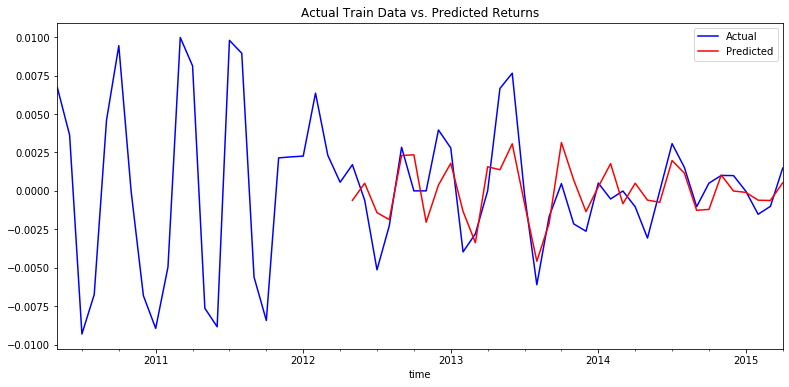

In [33]:
train_RMSE(train, results)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Max

SARIMA model RMSE on test data: 0.00322


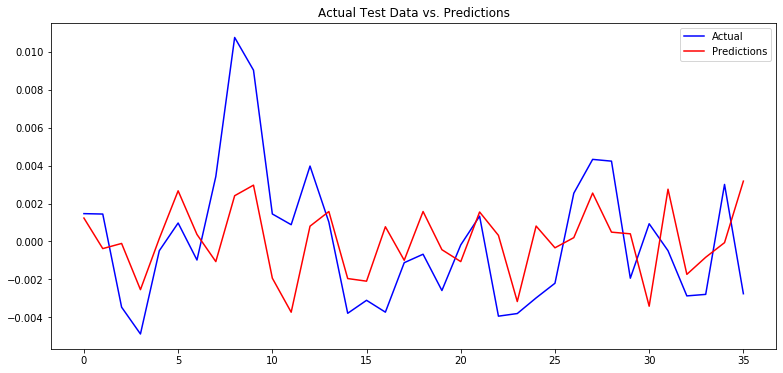

In [34]:
test_RMSE(ts_1d, pdq=pdq,pdqs=pdqs, display=True)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


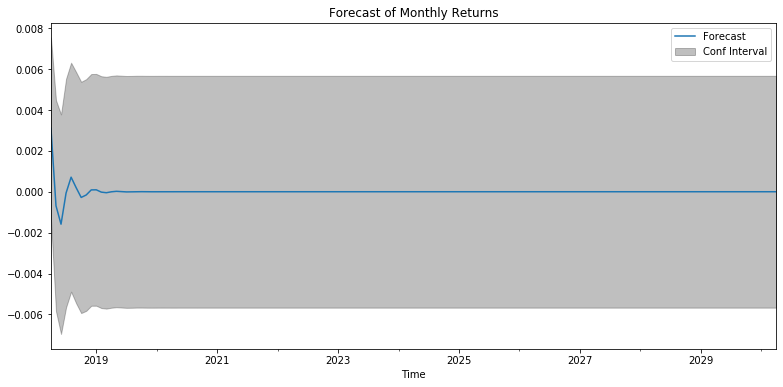

Total expected return in 1 year: 0.14%
Total expected return in 5 year: 0.14%
Total expected return in 10 years: 0.14%


In [35]:
Return_ts_1d = forecast_model(ts_1d, pdq=pdq, pdqs=pdqs, zc=29407)

### Alexandria 56308

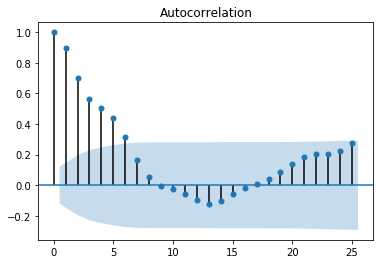

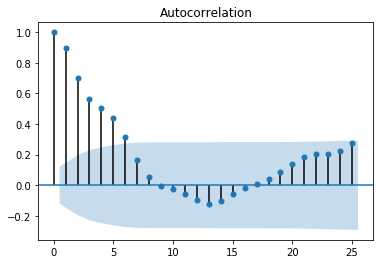

In [36]:
plot_acf(ts_3[:-1], alpha=.05)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


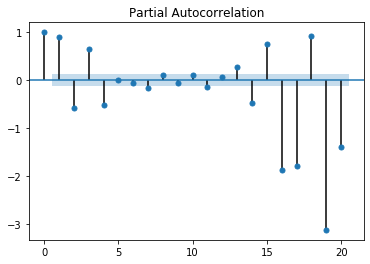

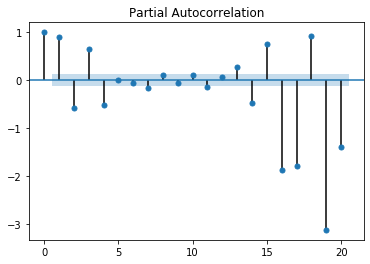

In [37]:
plot_pacf(ts_3[:-1], alpha=.05, lags=20)

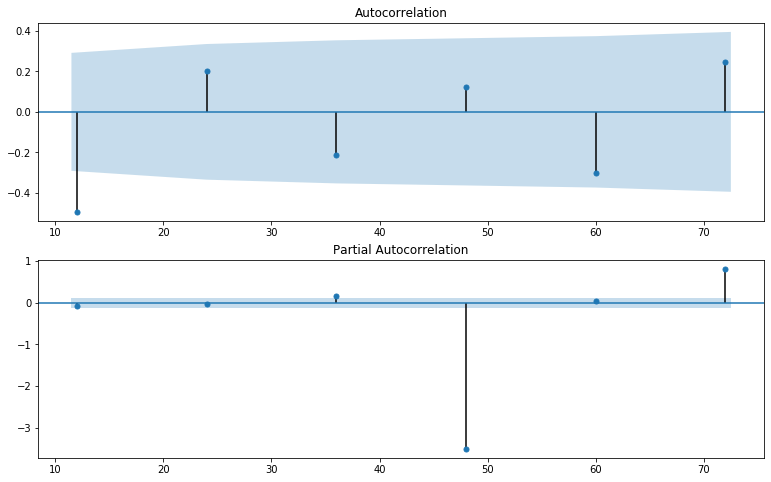

In [38]:
seasonal_plots(ts_3[:-1])

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  228
Model:               SARIMAX(2, 1, 1)   Log Likelihood                 976.935
Date:                Wed, 17 Jun 2020   AIC                          -1945.871
Time:                        22:50:04   BIC                          -1932.171
Sample:                    05-01-1996   HQIC                         -1940.343
                         - 04-01-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5426      0.044     12.437      0.000       0.457       0.628
ar.L2         -0.5448      0.043    -12.708      0.000      -0.629      -0.461
ma.L1          0.4745      0.044     10.837      0.0

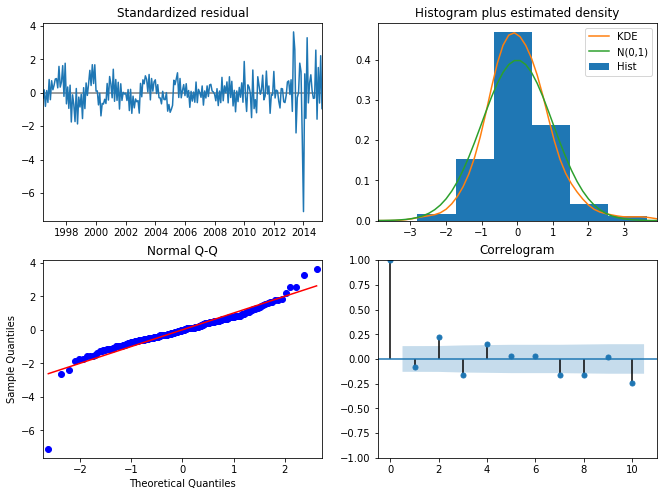

In [39]:
#Fit the SARIMA model and get results.
pdq = (2,1,1) #(AR, D, MA)
pdqs = (0,0,0,12)
train, test, results = model_fit(ts_3, pdq=pdq, pdqs=pdqs)

SARIMA model RMSE on train data: 0.00610


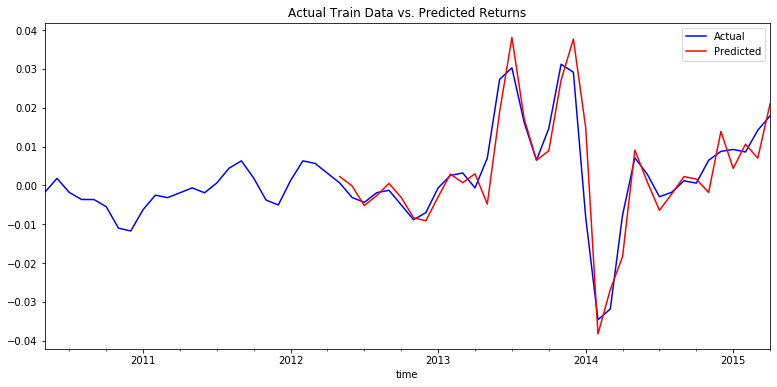

In [40]:
train_RMSE(train, results)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Max

SARIMA model RMSE on test data: 0.00318


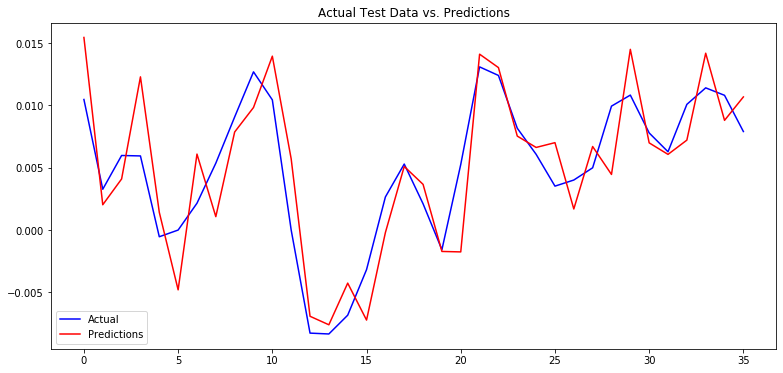

In [41]:
test_RMSE(ts_3, pdq=pdq,pdqs=pdqs, display=True)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


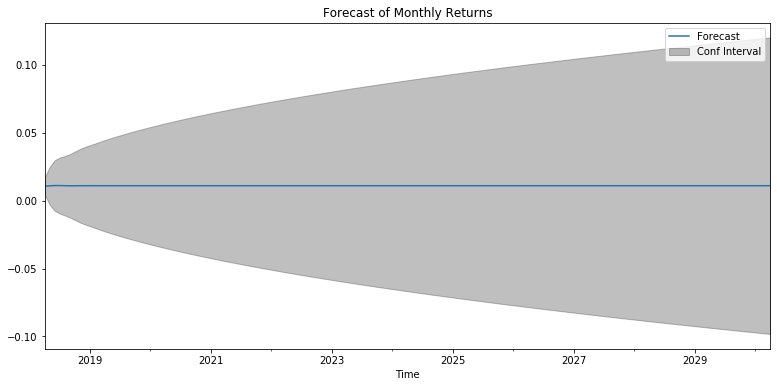

Total expected return in 1 year: 13.98%
Total expected return in 5 year: 92.52%
Total expected return in 10 years: 387.13%


In [42]:
Return_ts_3 = forecast_model(ts_3, pdq=pdq, pdqs=pdqs, zc=56308)

# Facebook Prophet Model

For another model we will be using the fb Prophet model to compare our results. The prophet model wants our data in a different format then Sarima. 

In [43]:
# import Face bookProphet
from fbprophet import Prophet
#Changing the data to run for Facebook Prophet
dfs_ts[0].reset_index(level=0, inplace=True)
dfs_ts[1].reset_index(level=0, inplace=True)
dfs_ts[2].reset_index(level=0, inplace=True)
dfs_ts[3].reset_index(level=0, inplace=True)
dfs_ts[4].reset_index(level=0, inplace=True)

dfs_ts[0].drop(['value'], axis=1, inplace=True)
dfs_ts[1].drop(['value'], axis=1, inplace=True)
dfs_ts[2].drop(['value'], axis=1, inplace=True)
dfs_ts[3].drop(['value'], axis=1, inplace=True)
dfs_ts[4].drop(['value'], axis=1, inplace=True)

dfs_ts[0].rename(columns={"time": "ds"}, inplace=True)
dfs_ts[1].rename(columns={"time": "ds"}, inplace=True)
dfs_ts[2].rename(columns={"time": "ds"}, inplace=True)
dfs_ts[3].rename(columns={"time": "ds"}, inplace=True)
dfs_ts[4].rename(columns={"time":"ds"}, inplace=True)


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/frame.py:4223: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Charleston 29407 FB

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



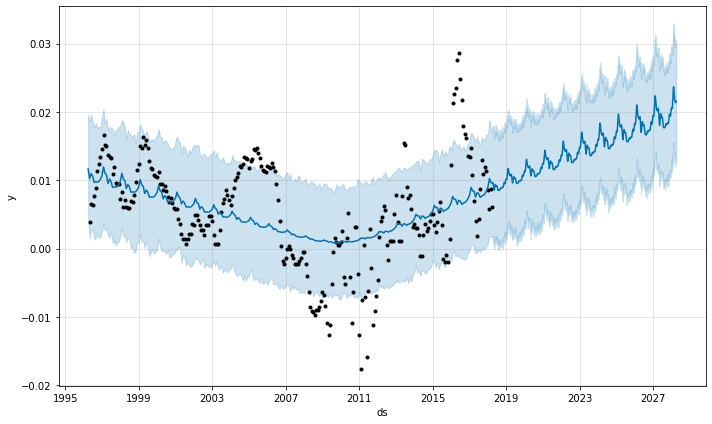

In [44]:
prophet = Prophet(seasonality_mode = 'multiplicative').fit(dfs_ts[0])

future = prophet.make_future_dataframe(periods=3652)
fcst = prophet.predict(future)
fig = prophet.plot(fcst)

In [45]:
forecast1 = prophet.predict(future)
forecast1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3912,2028-03-27,0.021448,0.012853,0.029324
3913,2028-03-28,0.021477,0.012665,0.029965
3914,2028-03-29,0.021509,0.013087,0.030477
3915,2028-03-30,0.021543,0.012697,0.029859
3916,2028-03-31,0.021579,0.012699,0.029981


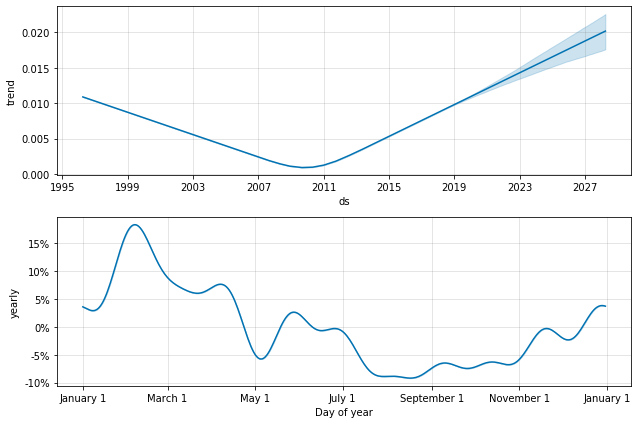

In [46]:
fig2 = prophet.plot_components(forecast1)

## Alexandria FB

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


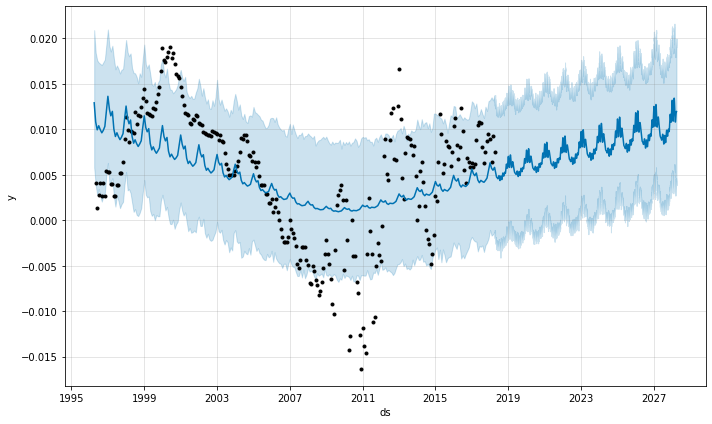

In [47]:
prophet = Prophet(seasonality_mode = 'multiplicative').fit(dfs_ts[3])

future = prophet.make_future_dataframe(periods=3652)
fcst = prophet.predict(future)
fig = prophet.plot(fcst)

In [48]:
forecast3 = prophet.predict(future)
forecast3[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3912,2028-03-27,0.011951,0.004194,0.019549
3913,2028-03-28,0.011965,0.004096,0.019459
3914,2028-03-29,0.011969,0.004384,0.019612
3915,2028-03-30,0.011963,0.003559,0.019501
3916,2028-03-31,0.011947,0.004022,0.019802


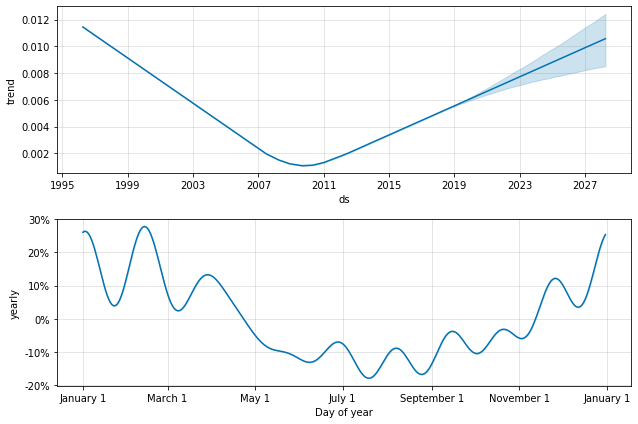

In [49]:
fig2 = prophet.plot_components(forecast3)